In [ ]:
# Install PyTorch Geometric
import torch
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import networkx as nx

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


KarateClub()
------------
Number of graphs: 1
Number of features: 34
Number of classes: 4
Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 

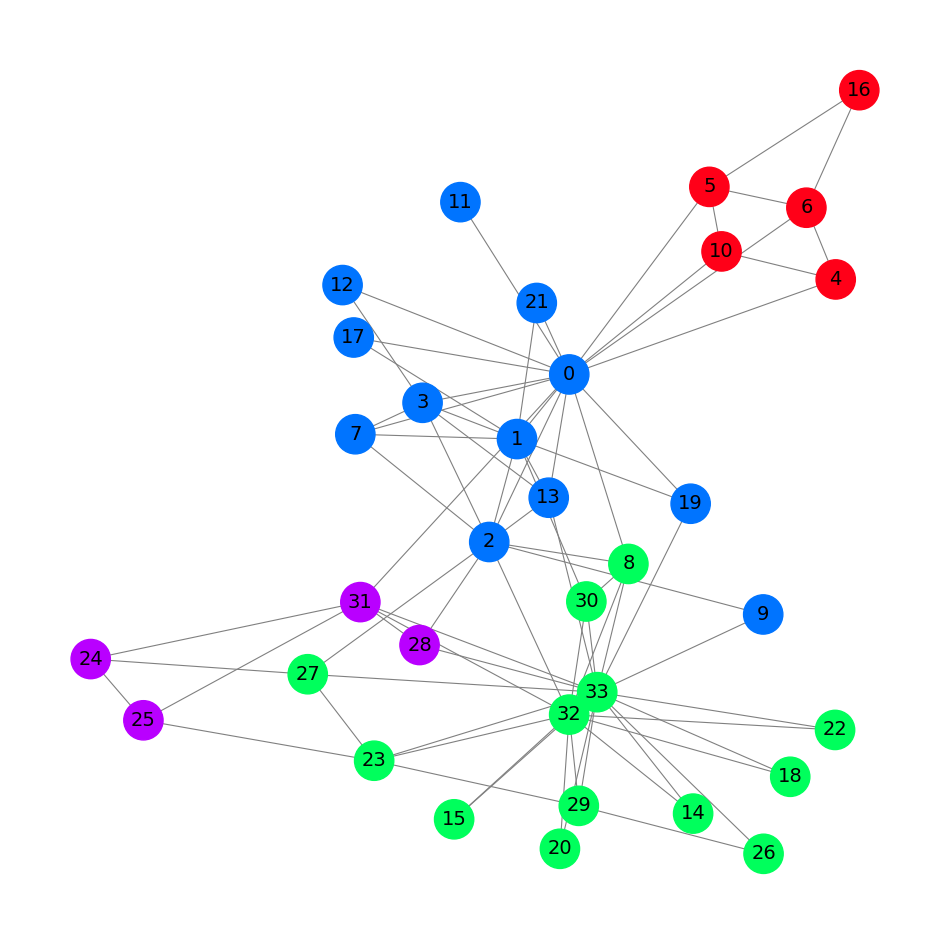

In [ ]:
from torch_geometric.datasets import KarateClub

# Import dataset from PyTorch Geometric
dataset = KarateClub()

# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print first element
print(f'Graph: {dataset[0]}')

data = dataset[0]

print(f'x = {data.x.shape}')
print(data.x)

print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

print(f'y = {data.y.shape}')
print(data.y)

print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

# Plot the graph
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
        pos=nx.spring_layout(G, seed=0),
        with_labels=True,
        node_size=800,
        node_color=data.y,
        cmap='hsv',
        vmin=-2,
        vmax=3,
        width=0.8,
        edge_color='grey',
        font_size=14
        )
plt.show()

In [17]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.gcn = GCNConv(dataset.num_features, 3)
    self.out = Linear(3, dataset.num_classes)

  def forward(self, x, edge_index):
    h = self.gcn(x, edge_index).relu()
    z = self.out(h)
    return h, z

model = GCN()
print(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)
Epoch   0 | Loss: 1.43 | Acc: 38.24%
Epoch  10 | Loss: 1.18 | Acc: 38.24%
Epoch  20 | Loss: 0.87 | Acc: 85.29%
Epoch  30 | Loss: 0.60 | Acc: 88.24%
Epoch  40 | Loss: 0.41 | Acc: 88.24%
Epoch  50 | Loss: 0.30 | Acc: 88.24%
Epoch  60 | Loss: 0.23 | Acc: 88.24%
Epoch  70 | Loss: 0.18 | Acc: 91.18%
Epoch  80 | Loss: 0.15 | Acc: 100.00%
Epoch  90 | Loss: 0.12 | Acc: 100.00%
Epoch 100 | Loss: 0.10 | Acc: 100.00%
Epoch 110 | Loss: 0.08 | Acc: 100.00%
Epoch 120 | Loss: 0.07 | Acc: 100.00%
Epoch 130 | Loss: 0.06 | Acc: 100.00%
Epoch 140 | Loss: 0.05 | Acc: 100.00%
Epoch 150 | Loss: 0.04 | Acc: 100.00%
Epoch 160 | Loss: 0.04 | Acc: 100.00%
Epoch 170 | Loss: 0.03 | Acc: 100.00%
Epoch 180 | Loss: 0.03 | Acc: 100.00%
Epoch 190 | Loss: 0.03 | Acc: 100.00%
Epoch 200 | Loss: 0.02 | Acc: 100.00%


In [18]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams['animation.bitrate'] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)

html = HTML(anim.to_html5_video())

In [19]:
display(html)

In [20]:
# Print embeddings
print(f'Final embeddings = {h.shape}')
print(h)

Final embeddings = torch.Size([34, 3])
tensor([[2.2943e+00, 0.0000e+00, 0.0000e+00],
        [2.6843e+00, 0.0000e+00, 0.0000e+00],
        [1.7979e+00, 0.0000e+00, 2.8166e-01],
        [2.5604e+00, 0.0000e+00, 0.0000e+00],
        [6.3785e-01, 2.2333e+00, 7.2628e-02],
        [5.3468e-01, 2.3988e+00, 1.3998e-01],
        [5.2763e-01, 2.4895e+00, 9.6995e-02],
        [2.1859e+00, 2.0214e-01, 1.8126e-01],
        [7.4066e-01, 5.1681e-01, 2.0733e+00],
        [1.7508e+00, 8.5069e-02, 6.3180e-01],
        [7.0195e-01, 2.2552e+00, 1.0673e-01],
        [2.0172e+00, 3.7373e-01, 2.9197e-01],
        [2.0751e+00, 3.8286e-01, 1.4620e-01],
        [1.9553e+00, 1.3611e-01, 5.3827e-01],
        [3.3036e-01, 4.7035e-01, 2.3331e+00],
        [4.2194e-01, 4.9437e-01, 2.3010e+00],
        [4.3485e-01, 2.3283e+00, 3.9846e-01],
        [2.1320e+00, 3.6854e-01, 3.2460e-01],
        [4.1036e-01, 5.6748e-01, 2.4022e+00],
        [1.8468e+00, 2.3496e-01, 5.4183e-01],
        [3.5751e-01, 4.6610e-01, 2.4450e+

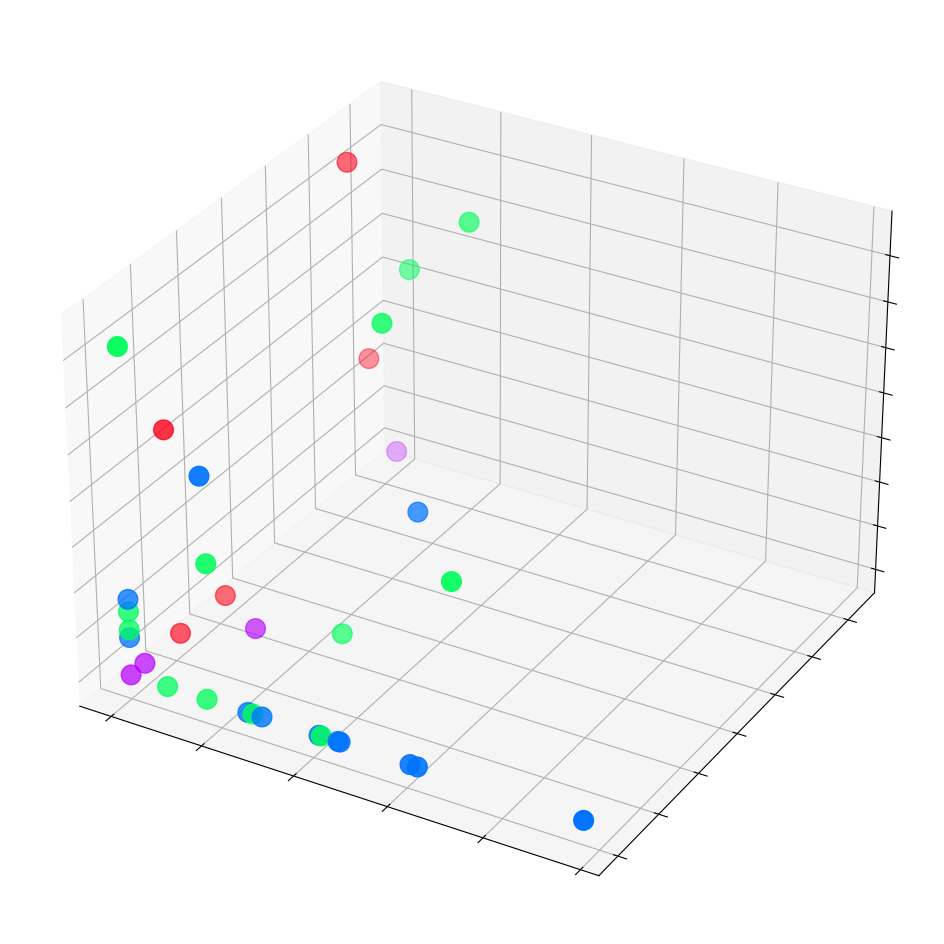

In [27]:
# Get first embedding at epoch = 0
embed = embeddings[0].detach().cpu().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
      s=200, c=data.y, cmap='hsv', vmin=-2, vmax=3)

plt.show()

In [28]:
%%capture

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
                np.arange(0, 200, 10), interval=800, repeat=True)

html = HTML(anim.to_html5_video())

In [29]:
display(html)